In [1]:
from streaming.base.format.mds.encodings import Encoding, _encodings
from streaming import MDSWriter, LocalDataset
from tqdm import tqdm
from typing import List
import torch
import json

class ListOfDict(Encoding):
    def encode(self, obj: List[dict]) -> bytes:
        # Convert the list of dictionaries to a JSON-encoded string
        json_str = json.dumps(obj)
        return json_str.encode('utf-8')

    def decode(self, data: bytes) -> List[dict]:

        # Decode the JSON-encoded string back to a list of dictionaries
        json_str = data.decode('utf-8')
        return json.loads(json_str)

# Register the custom encoding for 'list_of_dict'
_encodings['list_of_dict'] = ListOfDict

In [17]:
from glob import glob

files = glob('prepared-llava*.jsonl')
files

['prepared-llava-en.jsonl', 'prepared-llava-ms.jsonl']

In [19]:
a = set()
for f in files:
    with open(f) as fopen:
        for l in tqdm(fopen):
            l = json.loads(l)
            for i in range(len(l['conversations'])):
                splitted = l['conversations'][i]['content'].split('<')
                if len(splitted) > 1:
                    a.add(splitted[1].strip().split('\n')[0])
a

148657it [00:00, 158390.35it/s]
148657it [00:00, 152428.25it/s]


{'image>'}

In [3]:
columns = {
    'conversations': 'list_of_dict',
    'filename': 'list_of_dict'
}

hashes = 'sha1', 'xxh64'

In [4]:
!rm -rf mosaic-multimodal-vision-llava-only

In [5]:
with MDSWriter(out='mosaic-multimodal-vision-llava-only', columns=columns, compression=None, hashes=hashes) as out:
    for f in files:
        with open(f) as fopen:
            for l in tqdm(fopen):
                try:
                    l = json.loads(l)
                    for i in range(len(l['filename'])):
                        l['filename'][i] = l['filename'][i].replace('/output-audio', '/filter-audio')
                    for i in range(len(l['conversations'])):
                        l['conversations'][i]['content'] = l['conversations'][i]['content'].replace('\n<image>', ' <image>').replace('<image>\n', '<image>').replace('\n<audio>', ' <audio>').replace('<audio>\n', '<audio>').strip()
                        l['conversations'][i]['content'] = l['conversations'][i]['content'].replace('<image>', '<image> </image>').replace('<audio>', '<audio> </audio>')
                    out.write(l)
                except Exception as e:
                    print(l, e)

156564it [00:05, 29250.25it/s]
156564it [00:05, 28078.86it/s]


In [8]:
dataset = LocalDataset('mosaic-multimodal-vision-llava-only')
len(dataset)

313128

In [11]:
dataset[-1]

{'conversations': [{'role': 'user',
   'content': 'Bagaimana seseorang boleh membuat susunan yang serupa untuk bahagian tengah meja yang ringkas dan menyegarkan?\n<img src>'},
  {'role': 'assistant',
   'content': 'Untuk membuat susunan yang sama untuk bahagian tengah meja yang ringkas dan menyegarkan, seseorang boleh mengikuti langkah-langkah berikut:\n\n1. Pilih beberapa bunga segar, lebih baik dalam warna lembut dan menenangkan seperti merah jambu, putih atau lavender tulip dalam kes ini.\n2. Pilih bekas pasu atau kaca yang bersih dan minimalis untuk menampung bunga. Ketinggian dan lebar pasu hendaklah berkadar dengan panjang batang bunga dan bilangan bunga yang akan anda gunakan.\n3. Potong batang bunga mengikut panjang yang diingini, memastikan kepala bunga berada sedikit di atas rim pasu.\n4. Letakkan bunga dengan berhati-hati di dalam pasu, mengedarkannya secara sama rata untuk mencipta penampilan seimbang.\n5. Isi pasu dengan air untuk memastikan bunga segar dan sihat.\n6. Cari

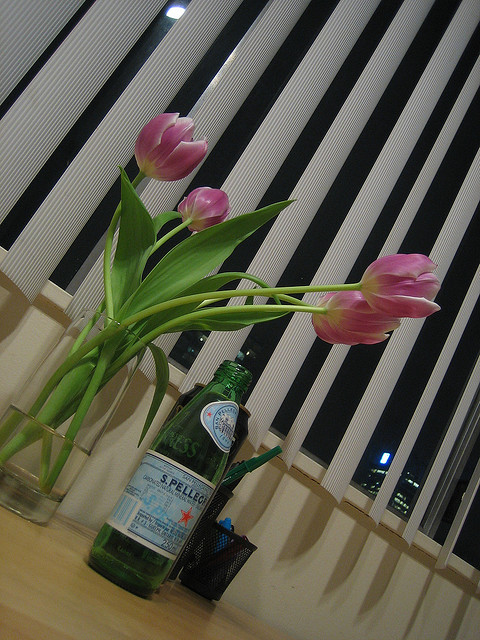

In [13]:
from PIL import Image

Image.open('/home/ubuntu/translated-LLaVA-Instruct-150K/filtered-llava-images/000000163917.jpg')